In [5]:
import  glob
import  fitsio
import  redrock
import  redrock.templates

import  pylab                  as      pl
import  numpy                  as      np
import  matplotlib.pyplot      as      plt
import  astropy.io.fits        as      fits
import  matplotlib.pyplot      as      plt

from    astropy.table          import  Table, join
from    astropy.coordinates    import  SkyCoord
from    astropy                import  units as u
from    desitarget.cmx         import  cmx_targetmask
from    desitarget             import  targetmask
from    desispec.interpolation import  resample_flux
from    desispec.resolution    import  Resolution
from    desispec.specscore     import  compute_frame_scores

In [6]:
##  DR7 cutouts
import requests

from   PIL                     import  Image
from   io                      import  BytesIO

In [7]:
plt.rcParams['figure.figsize'] = [10, 10]

In [8]:
%matplotlib inline

##  DR7 cutouts 

In [344]:
def get_dr7cutout(ra, dec):
  nim         = len(ra)
  nrow        =  np.maximum(np.floor(nim / 5).astype(np.int), 1)

  fig, axes   = plt.subplots(nrow, 5, figsize=(20, 5 * nrow))

  row         = 0
  col         = 0

  nmax        = np.minimum(5 * nrow, nim)
  
  for i in range(nmax):        
    url       = 'http://legacysurvey.org/viewer/jpeg-cutout?ra={:.4f}&dec={:.4f}&layer=decals-dr7&pixscale=0.27&bands=grz'.format(ra[i], dec[i])
    response  = requests.get(url)
    img       = Image.open(BytesIO(response.content))

    axes[row, col].imshow(img)
    
    col      += 1
    
    if col > 4:
        row  += 1
        col   = 0 

##  Night log.
http://desi-www.kpno.noao.edu:8090/nightsum/nightsum-2020-02-25/nightsum.html

##  Mini SV page.
https://desi.lbl.gov/trac/wiki/TargetSelectionWG/miniSV2

#  Summary 

- 5000 targets, 3873 with no fiber reach error.  478 skies.
- 2500 targets in coddd (with no scattered light problem, i.e. 5 petals).
- 2126 in coadd with no fiber reach problems.

- 1484 BGS targets.
- 1273 with no fiber reach problems.
- Gold: 1261 with no fiber reach problems and ZWARN==0. Of these, 741 are MAIN BRIGHT and 1261 are SV0.
- Of gold, 418 matches to GAMA; 4 erroneous redshift. 
- Of gold, 129 matches to SDSS; 1 erroneous redshift.

In [10]:
root  = '/global/cfs/cdirs/desi/spectro/redux/daily/tiles/70502/20200225/'

## Prep. redrock templates

In [11]:
templates = dict()

for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


## GET GAMA G12 TRUTH TABLES

In [12]:
GAMA  = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/GAMA-DR3-SpecObj-match.fits')
LGAMA = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/ls-dr8.0-GAMA-DR3-SpecObj-match.fits')

In [13]:
# Table(LGAMA)

In [14]:
# Table(GAMA)

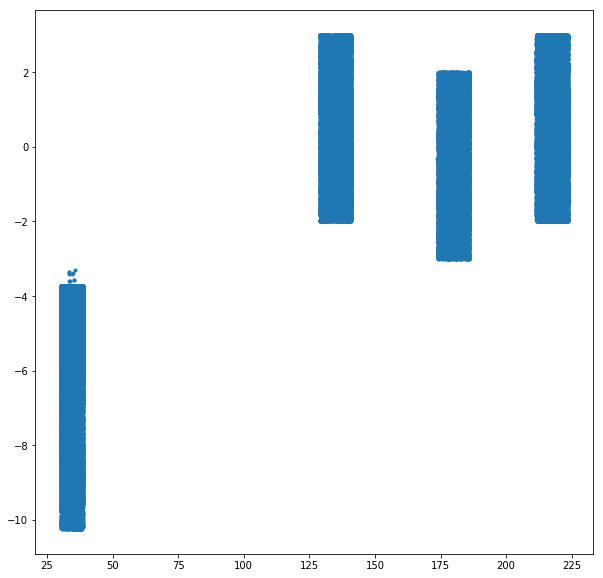

In [15]:
plt.rcParams['figure.figsize'] = [10, 10]

pl.plot(GAMA['RA'], GAMA['DEC'], '.')

In [16]:
##  Restrict to G12
isin   = (GAMA['RA'] < 200.) & (GAMA['RA'] > 150.)

G12    =  GAMA[isin]
LG12   =  LGAMA[isin]

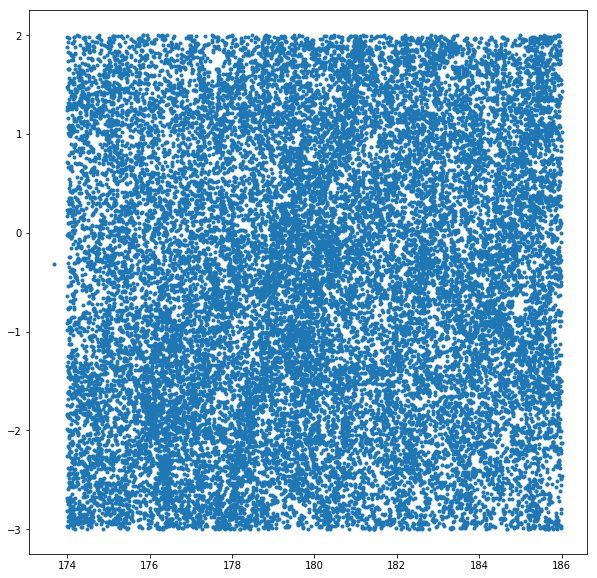

In [17]:
plt.rcParams['figure.figsize'] = [10, 10]

pl.plot(G12['RA'], G12['DEC'], '.')

In [18]:
##  GET SDSS redshifts  

In [19]:
SDSS  = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/sdss-specObj-dr14-unique-trimmed-match.fits')
LSDSS = fitsio.read('/project/projectdirs/desi/target/analysis/truth/dr8.0/south/matched/ls-dr8.0-sdss-specObj-dr14-unique-trimmed-match.fits')

##  Relevant exposure IDS 

In [20]:
# ALL EXPIDS
expids = glob.glob('/global/cfs/cdirs/desi/spectro/redux/daily/exposures/20200225/*')
expids = [x.split('/')[-1] for x in expids]

In [21]:
# BGS EXPIDS
bgs_expids = ['00052112', '00052113', '00052114', '00052115', '00052116'] 

In [22]:
# E.g.  /global/cfs/cdirs/desi/spectro/redux/daily/tiles/70502/20200225/cframe-b0-00052090.fits
cframes               = {}

for expid in bgs_expids:    
  cframes[expid]      = {}
    
  cframes[expid]['b'] = []
  cframes[expid]['r'] = []
  cframes[expid]['z'] = []

  ##  Fluxes 
  cframes[expid]['b'].append(fitsio.read('/global/cfs/cdirs/desi/spectro/redux/daily/tiles/70502/20200225/cframe-b0-{}.fits'.format(expid), ext=0))
  cframes[expid]['r'].append(fitsio.read('/global/cfs/cdirs/desi/spectro/redux/daily/tiles/70502/20200225/cframe-r0-{}.fits'.format(expid), ext=0))
  cframes[expid]['z'].append(fitsio.read('/global/cfs/cdirs/desi/spectro/redux/daily/tiles/70502/20200225/cframe-z0-{}.fits'.format(expid), ext=0)) 

##  GET COORDINATES FILE FOR FIBER REACH ERRORS
https://desi.lbl.gov/trac/wiki/FPS/PositionerFlags

In [23]:
# Coordinates
# ls /global/cfs/cdirs/desi/spectro/data/20200225/*/coordinates-*
fp    = {}
fas   = {}
coors = {}

for _ in bgs_expids:
  coors[_] = fitsio.read('/global/cfs/cdirs/desi/spectro/data/20200225/{}/coordinates-{}.fits'.format(_,_))

  fas[_]   = fitsio.read('/global/cfs/cdirs/desi/spectro/data/20200225/{}/fiberassign-070502.fits'.format(_))
    
  fp[_]    = join(Table(fas[_]), Table(coors[_]), keys=['TARGET_RA', 'TARGET_DEC'])
  fp[_].sort('TARGETID')

In [24]:
# Difference is the GFAs.
len(fas['00052112']), len(coors['00052112'])

(5000, 5126)

In [25]:
# https://desi.lbl.gov/trac/wiki/FPS/PositionerFlags
Table(coors['00052112'])[:10]

PETAL_LOC,DEVICE_LOC,CONVERGED,TARGET_RA,TARGET_DEC,FIBERASSIGN_X,FIBERASSIGN_Y,REQ_Q,REQ_S,REQ_X,REQ_Y,EXP_Q_0,EXP_S_0,FLAGS_EXP_0,EXP_X_0,EXP_Y_0,FVC_X_0,FVC_Y_0,FLAGS_FVC_0,CNT_X_0,CNT_Y_0,FLAGS_CNT_0,CNT_MAG_0,CNT_ERR_0,DX_0,DY_0,FPA_X_0,FPA_Y_0,FLAGS_COR_0,REQ_X_0,REQ_Y_0,OFFSET_0,EXP_Q_1,EXP_S_1,FLAGS_EXP_1,EXP_X_1,EXP_Y_1,FVC_X_1,FVC_Y_1,FLAGS_FVC_1,CNT_X_1,CNT_Y_1,FLAGS_CNT_1,CNT_MAG_1,CNT_ERR_1,DX_1,DY_1,FPA_X_1,FPA_Y_1,FLAGS_COR_1,REQ_X_1,REQ_Y_1,OFFSET_1,EXP_Q_2,EXP_S_2,FLAGS_EXP_2,EXP_X_2,EXP_Y_2,FVC_X_2,FVC_Y_2,FLAGS_FVC_2,CNT_X_2,CNT_Y_2,FLAGS_CNT_2,CNT_MAG_2,CNT_ERR_2,DX_2,DY_2,FPA_X_2,FPA_Y_2,FLAGS_COR_2,REQ_X_2,REQ_Y_2,OFFSET_2
int64,int64,int64,float64,float64,float32,float32,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64
0,0,0,180.00335405788294,-0.621495582398852,-0.8161547,-29.559782,268.433,29.5122,-0.807,-29.501,-91.56700482678802,29.51219500358265,4,-0.8070352584048036,-29.500984248411754,-32.748,-128.427,4,-59.96300000000019,-140.24800000000005,69,12.591,0.001,0.015,-0.027,-0.822,-29.506,69,-0.8069999999999999,-29.533,0.030886890422961,-91.56524613771153,29.544195983155205,4,-0.8070038284804425,-29.532997469859243,-32.75,-128.656,4,-59.88599999999997,-140.56100000000015,69,12.577,0.001,-0.012,-0.001,-0.8,-29.534,69,-0.812,-29.535,0.012041594578792296,-91.57482354534343,29.546339324256955,4,-0.8119993762986774,-29.535004653638484,-32.714,-128.671,4,-59.746999999999844,-140.4920000000002,69,12.584,0.001,0.012,0.01,-0.816,-29.535,69,-0.8039999999999999,-29.525,0.015620499351813309
0,1,0,180.0231341950373,-0.6507315506445961,-5.6288614,-36.67601,261.285,37.0345,-5.612,-36.607,-98.7149953887083,37.034501344861596,4,-5.611397695467422,-36.6065698348362,1.273,-179.515,4,-25.923999999999978,-191.288,69,12.634,0.001,0.011,-0.03,-5.625,-36.61,69,-5.614,-36.64,0.03195309061734092,-98.71115036179455,37.06794462446719,4,-5.614006023842825,-36.64000288491379,1.29,-179.755,4,-25.824999999999818,-191.5949999999998,69,12.661,0.001,-0.012,-0.005,-5.605,-36.637,69,-5.617,-36.642,0.013000000000000001,-98.71525523655997,37.07037515938638,4,-5.616999304401997,-36.64200298650849,1.312,-179.769,4,-25.69399999999996,-191.5540000000001,69,12.639,0.001,0.011,0.009,-5.62,-36.642,69,-5.609,-36.633,0.014212670403551895
0,2,0,179.98077758344465,-0.6404921089237555,4.6765695,-34.18345,277.805,34.438,4.677,-34.119,-82.19501441928672,34.43800188244677,4,4.676704446560656,-34.11869512226655,-72.248,-161.18,4,-99.39699999999993,-173.08199999999988,69,12.613,0.001,0.021,-0.02,4.657,-34.132,69,4.678,-34.152,0.029,-82.20039154731428,34.47117524482999,4,4.678004238925492,-34.15199951756062,-72.259,-161.419,4,-99.36400000000003,-173.3159999999998,69,12.707,0.001,-0.012,-0.005,4.686,-34.148,69,4.674,-34.153000000000006,0.013000000000000001,-82.20720975790012,34.47162141788797,4,4.674000605712774,-34.15299800079695,-72.23,-161.426,4,-99.23799999999983,-173.2779999999998,69,12.622,0.001,0.011,0.009,4.671,-34.153,69,4.682,-34.144,0.014212670403551895
0,3,0,180.03445477650894,-0.7029945365211852,-8.385128,-49.404007,260.375,50.0225,-8.363,-49.318,-99.62499880318101,50.02250549837621,4,-8.363566359348193,-49.31750361890276,20.294,-270.542,4,-6.80600000000004,-282.3879999999999,69,12.585,0.001,0.016,-0.019,-8.382,-49.336,69,-8.366,-49.355,0.02483948469674844,-99.62056926901467,50.05988582029831,4,-8.366000374457617,-49.35500274069925,20.309,-270.81,4,-6.719000000000051,-282.6080000000002,69,12.599,0.001,-0.01,-0.006,-8.36,-49.35,69,-8.37,-49.356,0.0116619037896906,-99.62488429242188,50.0615384

In [26]:
Table(fas['00052112'])[:10]

TARGETID,PETAL_LOC,DEVICE_LOC,LOCATION,FIBER,FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,PMRA_IVAR,PMDEC_IVAR,REF_EPOCH,LAMBDA_REF,FA_TARGET,FA_TYPE,OBJTYPE,FIBERASSIGN_X,FIBERASSIGN_Y,NUMTARGET,PRIORITY,SUBPRIORITY,OBSCONDITIONS,NUMOBS_MORE,RELEASE,BRICKID,BRICKNAME,BRICK_OBJID,MORPHTYPE,TARGET_RA_IVAR,TARGET_DEC_IVAR,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,FRACFLUX_G,FRACFLUX_R,FRACFLUX_Z,FRACMASKED_G,FRACMASKED_R,FRACMASKED_Z,FRACIN_G,FRACIN_R,FRACIN_Z,NOBS_G,NOBS_R,NOBS_Z,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,ALLMASK_G,ALLMASK_R,ALLMASK_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,WISEMASK_W1,WISEMASK_W2,MASKBITS,FRACDEV,FRACDEV_IVAR,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,SHAPEDEV_R_IVAR,SHAPEDEV_E1_IVAR,SHAPEDEV_E2_IVAR,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEEXP_R_IVAR,SHAPEEXP_E1_IVAR,SHAPEEXP_E2_IVAR,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_G_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_BP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_RP_MEAN_MAG,GAIA_PHOT_RP_MEAN_FLUX_OVER_ERROR,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_EXCESS_NOISE,GAIA_DUPLICATED_SOURCE,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PHOTSYS,CMX_TARGET,PRIORITY_INIT,NUMOBS_INIT,HPXPIXEL,BLOBDIST,FIBERFLUX_IVAR_G,FIBERFLUX_IVAR_R,FIBERFLUX_IVAR_Z,DESI_TARGET,BGS_TARGET,MWS_TARGET
int64,int16,int32,int32,int32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int64,uint8,bytes3,float32,float32,int16,int32,float64,int32,int32,int16,int32,bytes8,int32,bytes4,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,float32,float32,float32,float32,float32,float32,uint8,uint8,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bytes2,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,bool,float32,float32,bytes1,int64,int64,int64,int64,float32,float32,float32,float32,int64,int64,int64
35185718485585996,0,311,311,0,0,179.66987727167816,-1.6574385652529624,-7.681228,-3.264253,2.0258374,14.280712,2015.5,5400.0,545,1,TGT,82.18579,-288.26108,0,1000,0.232311560519591,65535,99,8000,321006,1796m017,4172,PSF,168177040000000.0,740727440000000.0,0.027289713,10.051535,35.056255,83.256966,684.63086,257.76917,57.142536,0.92239374,0.94703734,0.9700204,1.8116782e-05,1.7769367e-05,2.4871695e-05,0.12890169,0.073827125,0.017526086,0.9999997,0.99999964,0.75029933,4,5,3,1706.1888,682.32404,106.09397,1119.082,458.38928,69.090546,45.279636,25.168295,-3.0709102,-47.548084,2.5921524,0.42923066,0.00072050566,1.0495133e-05,0.9953859,0.9971638,0.9993944,0.9997713,0,0,0,7.8127766,27.248247,64.71331,7.8127766,27.248247,64.71331,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3602417082379287808,G2,18.712095,464.9532,19.628769,26.29529,17.708935,99.5623,1.3883798,0.35110453,False,0.629642,True,1.0867026,11.4330635,S,545,2463,1,25596,0.0,0.0,0.0,0.0,0,0,0
35185724529574460,0,272,272,1,0,179.75523346985221,-1.599430718530176,0.0,0.0,0.0,0.0,2015.5,5400.0,72057594037928192,1,TGT,60.752766,-272.98505,0,5000,0.4936894968225848,65535,99,8000,322447,1798m015,572,DEV,1351837500000.0,5213159700000.0,0.027733779,18.261003,59.709057,115.76403,311.15115,145.66374,32.562695,0.92118204,0.9461991,0.96954006,0.0011055123,0.001216456,0.00082549226,0.00057909294,0.0007289197,0.00094134087,0.9999999,1.0,0.9999999,4,6,4,1760.4818,807.0957,151.27748,1135.8314,542.3

In [27]:
# Good fiber across exposures.
tids   = []

for _ in fp.keys():
    tids += list(fp[_]['TARGETID'])

In [28]:
tids   = np.unique(tids)
isgood = np.ones_like(tids)

In [29]:
for _ in fp.keys():
  # End of positioning sequence, look for largest FLAGS_EXP_N.  2 in this case.
  isgood = isgood & (fp[_]['FLAGS_EXP_2'] == 4)

##  NUMBER OF FIBER REACH ERRORS FOR ALL TARGETS ON PLATE

In [30]:
np.count_nonzero(isgood), len(tids)

(3873, 5000)

##   GET COADDED EXPOSURES AND ZBEST FILES

In [217]:
coadds      = {}
zbests      = {}

coadds_wave = {}
coadds_flux = {}
coadds_res  = {}
coadds_ivar = {}
coadds_mask = {}

coadds_bsnr = {}
coadds_rsnr = {}
coadds_zsnr = {}
coadds_tsnr = {}

In [32]:
# XTENSION= 'IMAGE   '           / Image extension                                
# BITPIX  =                  -32 / array data type                                
# NAXIS   =                    2 / number of array dimensions                     
# NAXIS1  =                 7781                                                  
# NAXIS2  =                  500                                                  
# PCOUNT  =                    0 / number of parameters                           
# GCOUNT  =                    1 / number of groups                               
# EXTNAME = 'BRZ_FLUX'           / extension name                                 
# BUNIT   = '10**-17 erg/(s cm2 Angstrom)'                                        
# CHECKSUM= '1gAq4f6n1fAn1f3n'   / HDU checksum updated 2020-02-26T06:51:09       
# DATASUM = '1442897442'         / data unit checksum updated 2020-02-26T06:51:09 

In [33]:
# XTENSION= 'IMAGE   '           / Image extension                                
# BITPIX  =                  -32 / array data type                                
# NAXIS   =                    2 / number of array dimensions                     
# NAXIS1  =                 7781                                                  
# NAXIS2  =                  500                                                  
# PCOUNT  =                    0 / number of parameters                           
# GCOUNT  =                    1 / number of groups                               
# EXTNAME = 'BRZ_IVAR'           / extension name                                 
# BUNIT   = '10**+34 (s2 cm4 Angstrom2) / erg2'                                   
# CHECKSUM= '4aSk6XPj4aPj4WPj'   / HDU checksum updated 2020-02-26T06:51:09       
# DATASUM = '966772586'          / data unit checksum updated 2020-02-26T06:51:09 

In [218]:
bandpasses              = {"b": [4000, 5800], "r": [5800, 7600], "z": [7600, 9800]}
petals                  = [0, 3, 6, 7, 9]

wave                    = fitsio.read(root + 'coadd-{}-70502-20200225.fits'.format(0), ext=2)

for petal in petals:
    print('\n\nSolving for petal: {}'.format(petal))
    
    ##  FIRST EXT: FIBER MAPS
    coadds[petal]       = fitsio.read(root + 'coadd-{}-70502-20200225.fits'.format(petal))    
    zbests[petal]       = fitsio.read(root + 'zbest-{}-70502-20200225.fits'.format(petal))
    
    coadds_wave[petal]  = fitsio.read(root + 'coadd-{}-70502-20200225.fits'.format(petal), ext=2)
    coadds_flux[petal]  = fitsio.read(root + 'coadd-{}-70502-20200225.fits'.format(petal), ext=3) 
    coadds_ivar[petal]  = fitsio.read(root + 'coadd-{}-70502-20200225.fits'.format(petal), ext=4)
    coadds_mask[petal]  = fitsio.read(root + 'coadd-{}-70502-20200225.fits'.format(petal), ext=5)
    coadds_res[petal]   = fitsio.read(root + 'coadd-{}-70502-20200225.fits'.format(petal), ext=6) 

    assert  np.all(wave == coadds_wave[petal])
    
    mask                = np.clip(coadds_mask[petal].astype(np.float), a_max=1.0, a_min=0.0).astype(bool)
    
    dwave               = np.gradient(wave)
    
    bwave               = ((wave < bandpasses['b'][0]) | (wave > bandpasses['b'][1])) 
    bwave               = np.repeat(bwave[:, np.newaxis], 500, axis=1).T

    rwave               = ((wave < bandpasses['r'][0]) | (wave > bandpasses['r'][1])) 
    rwave               = np.repeat(rwave[:, np.newaxis], 500, axis=1).T
    
    zwave               = ((wave < bandpasses['z'][0]) | (wave > bandpasses['z'][1])) 
    zwave               = np.repeat(zwave[:, np.newaxis], 500, axis=1).T
    
    bmask               = mask | bwave
    rmask               = mask | rwave
    zmask               = mask | zwave
    
    dwave               = np.repeat(dwave[:, np.newaxis], 500, axis=1).T
    
    # https://github.com/desihub/desispec/blob/c544749a8ab4b982a054b91247f056c2ce4bd8ce/py/desispec/specscore.py#L148    
    coadds_snr          = coadds_flux[petal] * np.sqrt(coadds_ivar[petal]) / np.sqrt(dwave)
    
    coadds_bsnr[petal]  = np.sum(coadds_snr * (1. - bmask.astype(np.float)), axis=-1)
    coadds_rsnr[petal]  = np.sum(coadds_snr * (1. - rmask.astype(np.float)), axis=-1)
    coadds_zsnr[petal]  = np.sum(coadds_snr * (1. - zmask.astype(np.float)), axis=-1)
    
    coadds_tsnr[petal]  = np.sqrt(coadds_bsnr[petal]**2. + coadds_rsnr[petal]**2. + coadds_zsnr[petal]**2.)



Solving for petal: 0


Solving for petal: 3


Solving for petal: 6


Solving for petal: 7


Solving for petal: 9


In [219]:
##  Assumes similar across exposures. 
wave           = coadds_wave[0]

##  Stack across petals. 
acoadds_flux   = np.vstack((coadds_flux[0], coadds_flux[3], coadds_flux[6], coadds_flux[7], coadds_flux[9]))
acoadds_mask   = np.vstack((coadds_mask[0], coadds_mask[3], coadds_mask[6], coadds_mask[7], coadds_mask[9]))

acoadds_bsnr   = np.hstack((coadds_bsnr[0], coadds_bsnr[3], coadds_bsnr[6], coadds_bsnr[7], coadds_bsnr[9]))
acoadds_rsnr   = np.hstack((coadds_rsnr[0], coadds_rsnr[3], coadds_rsnr[6], coadds_rsnr[7], coadds_rsnr[9]))
acoadds_zsnr   = np.hstack((coadds_zsnr[0], coadds_zsnr[3], coadds_zsnr[6], coadds_zsnr[7], coadds_zsnr[9]))
acoadds_tsnr   = np.hstack((coadds_tsnr[0], coadds_tsnr[3], coadds_tsnr[6], coadds_tsnr[7], coadds_tsnr[9]))

acoadds_res    = np.vstack((coadds_res[0], coadds_res[3], coadds_res[6], coadds_res[7], coadds_res[9]))

acoadds        = np.hstack((coadds[0], coadds[3], coadds[6], coadds[7], coadds[9]))
azbests        = np.hstack((zbests[0], zbests[3], zbests[6], zbests[7], zbests[9]))

##  Sort COADDS by TARGETID and keep those with NO FIBER REACH ERROR.

In [220]:
inds           = np.argsort(acoadds['TARGETID'])

In [221]:
acoadds        = acoadds[inds]
azbests        = azbests[inds]

acoadds_flux   = acoadds_flux[inds]
acoadds_mask   = acoadds_mask[inds]

acoadds_bsnr   = acoadds_bsnr[inds]
acoadds_rsnr   = acoadds_rsnr[inds]
acoadds_zsnr   = acoadds_zsnr[inds]
acoadds_tsnr   = acoadds_tsnr[inds]

In [222]:
assert  len(acoadds) == len(azbests)

In [223]:
len(acoadds['TARGETID'])

2500

In [224]:
# tids is the list of target ids assigned (not all reduced given scattered light on some petals). 
in_coadd       = [x in acoadds['TARGETID'] for x in tids]

In [225]:
np.count_nonzero(in_coadd), np.count_nonzero(isgood[in_coadd])

(2500, 2126)

In [226]:
tids           =   tids[in_coadd]
isgood         = isgood[in_coadd]

In [227]:
len(tids), len(azbests), len(acoadds), np.count_nonzero(isgood)

(2500, 2500, 2500, 2126)

In [228]:
assert  np.all(tids == acoadds['TARGETID'])

##  Get sky fibers

In [229]:
SKIES          = (acoadds['DESI_TARGET'] & targetmask.desi_mask.mask('SKY')) != 0
np.count_nonzero(SKIES)

478

In [230]:
skies_acoadds_flux = acoadds_flux[SKIES]
skies_acoadds_flux.shape

(478, 7781)

(0.001, 4.734209499239093)

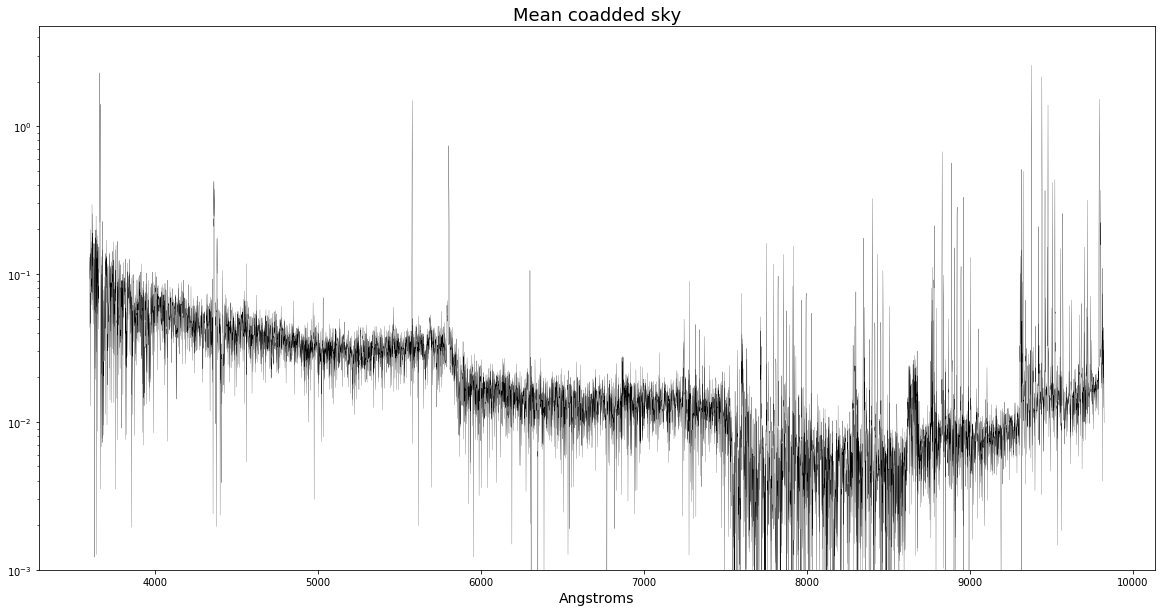

In [231]:
plt.rcParams['figure.figsize'] = [20, 10]

pl.semilogy(wave, np.abs(np.mean(skies_acoadds_flux, axis=0)), lw=0.2, c='k')
pl.xlabel('Angstroms', fontsize=14)
pl.title('Mean coadded sky', fontsize=18)
pl.ylim(bottom=1.e-3)

##  Keep BGS targets only, distinguishing between MAIN_BRIGHT and SV0 

In [232]:
IS_MSV_BRIGHT  = (acoadds['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('MINI_SV_BGS_BRIGHT')) != 0
IS_SV0         = (acoadds['CMX_TARGET'] & cmx_targetmask.cmx_mask.mask('SV0_BGS')) != 0

IS_BGS         = IS_MSV_BRIGHT | IS_SV0 
IS_GOOD_BGS    = IS_BGS & isgood

IS_GOOD_BGS    = IS_GOOD_BGS.astype(bool)
IS_ZGOOD_BGS   = IS_GOOD_BGS & (azbests['ZWARN'] == 0)

IS_MSV_BRIGHT  = IS_MSV_BRIGHT[IS_ZGOOD_BGS]
IS_SV0         =        IS_SV0[IS_ZGOOD_BGS]

##  N BGS TARGETS, WITH NO FIBER ERROR, AND GOOD Z, OF TYPE MAIN BRIGHT, OF TYPE SV0

In [233]:
np.count_nonzero(IS_BGS), np.count_nonzero(IS_GOOD_BGS), np.count_nonzero(IS_ZGOOD_BGS), np.count_nonzero(IS_MSV_BRIGHT), np.count_nonzero(IS_SV0)

(1484, 1273, 1261, 741, 1261)

In [234]:
bgs_acoadds      =      acoadds[IS_ZGOOD_BGS]
bgs_azbests      =      azbests[IS_ZGOOD_BGS]
bgs_acoadds_res  =  acoadds_res[IS_ZGOOD_BGS]
bgs_acoadds_flux = acoadds_flux[IS_ZGOOD_BGS]
bgs_acoadds_mask = acoadds_mask[IS_ZGOOD_BGS]

bgs_acoadds_bsnr = acoadds_bsnr[IS_ZGOOD_BGS]
bgs_acoadds_rsnr = acoadds_rsnr[IS_ZGOOD_BGS]
bgs_acoadds_zsnr = acoadds_zsnr[IS_ZGOOD_BGS]
bgs_acoadds_tsnr = acoadds_tsnr[IS_ZGOOD_BGS]

In [ ]:
get_dr7cutout(bgs_acoadds['TARGET_RA'][0:50], bgs_acoadds['TARGET_DEC'][0:50])

In [235]:
# len(bgs_acoadds), len(bgs_azbests)

In [236]:
bgs_azbests                    = Table(bgs_azbests)

bgs_azbests['IS_SV0']          = IS_SV0
bgs_azbests['IS_MSV_BRIGHT']   = IS_MSV_BRIGHT

In [237]:
# len(bgs_azbests), np.count_nonzero(bgs_azbests['ZWARN'] > 0)

In [238]:
bgs_acoadds                    = Table(bgs_acoadds)

bgs_acoadds['IS_SV0']          = IS_SV0
bgs_acoadds['IS_MSV_BRIGHT']   = IS_MSV_BRIGHT

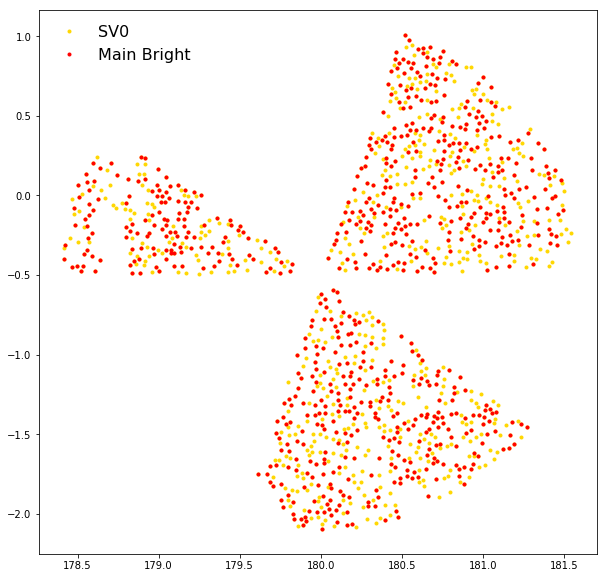

In [239]:
plt.rcParams['figure.figsize'] = [10, 10]

pl.plot(bgs_acoadds['TARGET_RA'][IS_SV0],        bgs_acoadds['TARGET_DEC'][IS_SV0], '.', c='gold', label='SV0')
pl.plot(bgs_acoadds['TARGET_RA'][IS_MSV_BRIGHT], bgs_acoadds['TARGET_DEC'][IS_MSV_BRIGHT], '.', c='r', label='Main Bright')

pl.legend(loc=2, frameon=False, fontsize=16)

##  What determines redshift success?

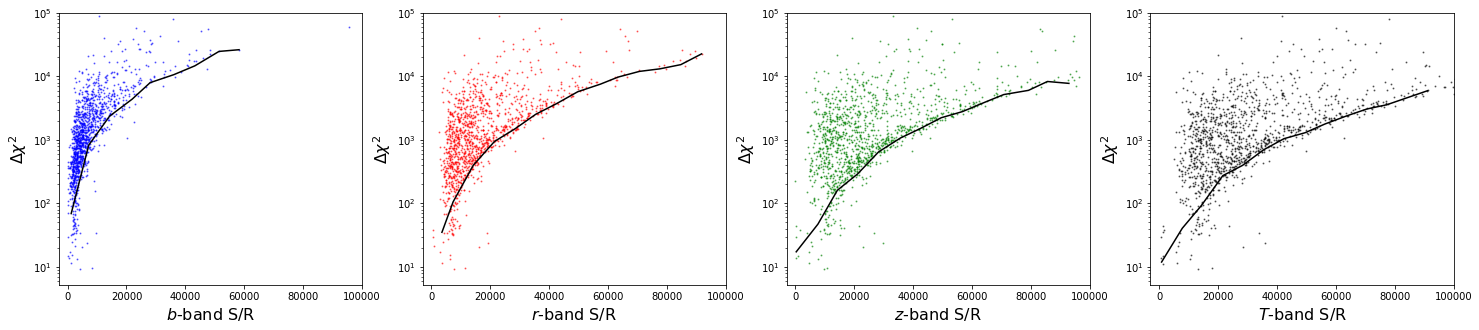

In [302]:
import scipy

from scipy.ndimage     import gaussian_filter
from scipy.interpolate import interp1d


fig, axes = plt.subplots(1, 4, figsize=(25,5)) 

for i, (b, c, band) in enumerate(zip([bgs_acoadds_bsnr, bgs_acoadds_rsnr, bgs_acoadds_zsnr, bgs_acoadds_tsnr], ['b', 'r', 'g', 'k'], ['b', 'r', 'z', 'T'])):
  limits  = np.arange(0.0, 1.e5, 7.e3)
  bdig    = np.digitize(b[b>0.0], bins=limits)  
  
  bmean   = []
  mean    = []
    
  for j in range(len(limits)):
    try:
        _mean  = np.percentile(bgs_azbests['DELTACHI2'][b > 0.0][bdig == j], 5)
        _bmean = np.percentile(b[b > 0.0][bdig == j], 5)
    
    except:
        _mean  = np.median(bgs_azbests['DELTACHI2'][b > 0.0][bdig == j]) 
        _bmean = np.median(b[b > 0.0][bdig == j])
    
    bmean.append(_bmean)
    mean.append(_mean)

  bmean   = np.array(bmean)
  mean    = np.array(mean) 
    
  # mean  = gaussian_filter(mean, 1)

  axes[i].semilogy(b[b > 0.0], bgs_azbests['DELTACHI2'][b > 0.0], marker='.', lw=0.0, markersize=2, c=c, alpha=0.5)

  axes[i].semilogy(bmean, mean, c='k')

  axes[i].set_xlim(right=1.e5, left=-3000.)
  axes[i].set_ylim(  top=1.e5)

  axes[i].set_xlabel(r'${}$-band S/R'.format(band), fontsize=16)
  axes[i].set_ylabel(r'$\Delta \chi^2$', fontsize=16)

##  Example of coadded flux

In [ ]:
def bestfit_compare(i, ax, zbests, coadds_flux):
    zbest    = Table(zbests)[i]

    z        = zbest['Z']
    zerr     = zbest['ZERR']
    dchi2    = zbest['DELTACHI2']
    zwarn    = zbest['ZWARN']
    targetid = zbest['TARGETID']
    spectype = zbest['SPECTYPE'].strip()
    subtype  = zbest['SUBTYPE'].strip()

    fulltype = (spectype, subtype)

    ncoeff   = templates[fulltype].flux.shape[0]
    coeff    = zbest['COEFF'][0:ncoeff]

    tflux    = templates[fulltype].flux.T.dot(coeff)
    twave    = templates[fulltype].wave * (1. + z)

    # R      = Resolution(res)
    # txflux = R.dot(resample_flux(wave, twave, tflux))
    
    ax.plot(wave, coadds_flux[i,:], lw=1.0, label='z: {} +- {} (ZWARN == {}, SPECTYPE={}, SUBTYPE={}, $\Delta \chi^2$ = {})'.format(z, zerr, zwarn, spectype, subtype, dchi2))
    ax.plot(twave + 5.,            tflux, lw=1.0)
    # ax.plot( wave,              txflux, lw=1.0)

    ax.legend(loc=2, frameon=False)
    
    ax.set_xlim(3500., 10000.)
    ax.set_ylim(bottom = -2.5)

In [ ]:
nspec     = 10
fig, axes = plt.subplots(nspec, figsize=(20, 50))

best      = np.argsort(bgs_azbests['DELTACHI2'])[::-1]
isin      = bgs_azbests['DELTACHI2'][best] < 100.

for i in range(10):
  #  [best][isin]
  bestfit_compare(i, axes[i], bgs_azbests, bgs_acoadds_flux)

for ax in fig.get_axes():
    ax.label_outer()

In [ ]:
bgs_acoadds_bsnr.shape

##  Match to G12

In [ ]:
# Matching
def matches(bgs_acoadds, spec, _RA='RA', _DEC='DEC'):
  c              = SkyCoord(ra=bgs_acoadds['TARGET_RA']*u.degree, dec=bgs_acoadds['TARGET_DEC']*u.degree)
  catalog        = SkyCoord(ra=spec[_RA]*u.degree, dec=spec[_DEC]*u.degree)

  idx, d2d, d3d  = c.match_to_catalog_sky(catalog)

  max_sep        = 1.0 * u.arcsec

  sep_constraint = d2d < max_sep

  c              = c[sep_constraint]

  _matches       = catalog[idx[sep_constraint]]

  coadd_matches  = bgs_acoadds[sep_constraint]
  flux_matches   = bgs_acoadds_flux[sep_constraint]
  mask_matches   = bgs_acoadds_mask[sep_constraint]
  zbest_matches  = bgs_azbests[sep_constraint] 
  spec_matches   =     spec[idx[sep_constraint]]
    
  return  coadd_matches, zbest_matches, spec_matches, flux_matches, mask_matches

In [ ]:
gcoadd_matches, gzbest_matches, gama_matches, gflux_matches, gmask_matches =  matches(bgs_acoadds, G12)

In [ ]:
# Sanity check
# dra, ddec      = c.spherical_offsets_to(_matches)

In [ ]:
#dra.arcsec, ddec.arcsec

In [ ]:
len(gama_matches)

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]

_ = np.arange(0.0, 1.0, 0.1)

pl.plot(_, _, 'k-', lw=0.1)

pl.plot(gama_matches['Z'][gzbest_matches['IS_SV0'] == True],        gzbest_matches['Z'][gzbest_matches['IS_SV0'] == True], '.', c='r', label='SV0')
pl.plot(gama_matches['Z'][gzbest_matches['IS_MSV_BRIGHT'] == True], gzbest_matches['Z'][gzbest_matches['IS_MSV_BRIGHT'] == True], '.', c='g', label='BRIGHT')

pl.legend(loc=1)

pl.xlabel('G12 $z$', fontsize=12)
pl.ylabel('rr $z$', fontsize=12) 

##  Match to SDSS

In [ ]:
# Table(SDSS)

In [ ]:
scoadd_matches, szbest_matches, sdss_matches, sflux_matches, smask_matches =  matches(bgs_acoadds, SDSS, _RA='PLUG_RA', _DEC='PLUG_DEC')

NameError: name 'sdss_matches' is not defined

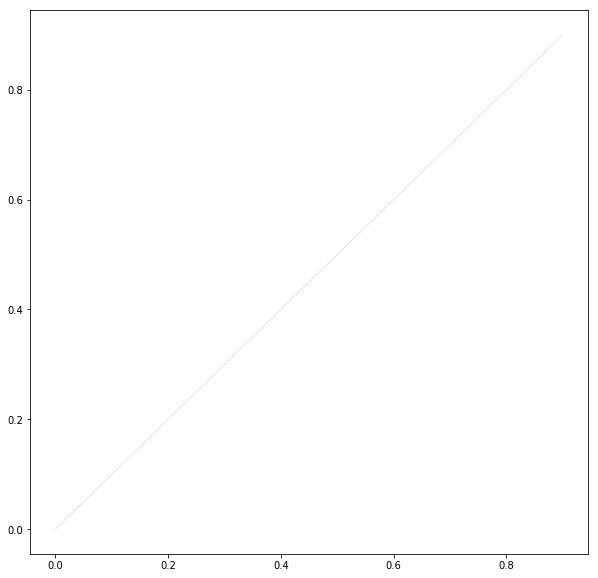

In [346]:
plt.rcParams['figure.figsize'] = [10, 10]

_              = np.arange(0.0, 1.0, 0.1)

pl.plot(_, _, 'k-', lw=0.1)

pl.plot(sdss_matches['Z'][szbest_matches['IS_SV0'] == True],        szbest_matches['Z'][szbest_matches['IS_SV0'] == True], '.', c='r', label='SV0')
pl.plot(sdss_matches['Z'][szbest_matches['IS_MSV_BRIGHT'] == True], szbest_matches['Z'][szbest_matches['IS_MSV_BRIGHT'] == True], '.', c='g', label='BRIGHT')

pl.legend(loc=1)

pl.xlabel('SDSS $z$', fontsize=12)
pl.ylabel('rr $z$', fontsize=12)

In [347]:
get_dr7cutout(scoadd_matches['TARGET_RA'][0:10], scoadd_matches['TARGET_DEC'][0:10])

NameError: name 'scoadd_matches' is not defined

In [ ]:
len(sdss_matches)

In [ ]:
##  os.system('http://legacysurvey.org/viewer/cutout.fits?ra=186.3882&dec=12.2592&layer=dr8&pixscale=1.00']

In [ ]:
##  Table(sdss_matches)

##  SDSS spectra for comparison (rr z > 1.0)

In [ ]:
def get_sdss_spectra(sdss_matches):
  waves  = []
  bspecs = []
  bmasks = []

  for survey, plate, mjd, fiber in zip(sdss_matches['SURVEY'], sdss_matches['PLATE'], sdss_matches['MJD'], sdss_matches['FIBERID']):    
    survey     = survey.decode('utf-8').strip()
    exists     = False
 
    wave       = None
    bspec      = None
    
    # print('Finding {} {} {} {}'.format(survey, plate, mjd, fiber))

    for _ in ['v5_10_0', '103', '104', '26']:
      fpath    = '/project/projectdirs/cosmo/data/sdss/dr14/{}/spectro/redux/{}/spectra/{:04d}/spec-{:04d}-{}-{:04d}.fits'.format(survey, _, plate, plate, mjd,fiber)
    
      try:      
        bspec  = fitsio.read(fpath)    
        exists = True

        wave   = 10. ** bspec['loglam']
        bmask  = np.clip(bspec['and_mask'].astype(np.float), a_max=1.0, a_min=0.0)
        bspec  = bspec['flux']
            
        waves.append(wave)
        bspecs.append(bspec) 
        bmasks.append(bmask)
        
      except:            
        continue
    
      # print('Found.')

      break

    if exists == False:
      waves.append(None)
      bspecs.append(None) 
      bmasks.append(None)
        
  return  waves, bspecs, bmasks

In [ ]:
sdss_matches.shape

In [ ]:
sdss_waves, sdss_bspecs, sdss_bmasks = get_sdss_spectra(sdss_matches)

In [ ]:
len(sdss_waves)

In [ ]:
# sdss_bmasks

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]

for i, w in enumerate(sdss_waves):
  if w is not None:
    pl.semilogy(w, sdss_bspecs[i])

  if i > 1:
    break
    
pl.title('SDSS SPECTRA OF BGS MATCHES')
pl.ylim(bottom=1.)

In [ ]:
len(sdss_waves), len(sdss_bspecs)

In [ ]:
def sdss_compare(i, plotted, ax, zbests, coadds_flux, coadds, sdss_wave, sdss_flux, plot_sdss=True, plot_redrock=True, plot_desi=False):
    zbest    = Table(zbests)[i]

    z        = zbest['Z']
    zerr     = zbest['ZERR']
    dchi2    = zbest['DELTACHI2']
    zwarn    = zbest['ZWARN']
    targetid = zbest['TARGETID']
    spectype = zbest['SPECTYPE'].strip()
    subtype  = zbest['SUBTYPE'].strip()

    fulltype = (spectype, subtype)

    ncoeff   = templates[fulltype].flux.shape[0]
    coeff    = zbest['COEFF'][0:ncoeff]

    tflux    = templates[fulltype].flux.T.dot(coeff)
    twave    = templates[fulltype].wave * (1. + z)

    if sdss_wave[i] is not None:
      if plot_sdss:
        ax.plot(sdss_wave[i], sdss_flux[i], label='{}; Petal {}; Device Loc. {}.'.format(zbests['TARGETID'][i], coadds['PETAL_LOC'][i], coadds['DEVICE_LOC'][i]))

      if plot_desi:
        ax.plot(wave, coadds_flux[i,:], lw=1.0, label='{}, z: {} +- {} (ZWARN == {}, SPECTYPE={}, SUBTYPE={}, $\Delta \chi^2$ = {})'.format(zbests['TARGETID'][i], z, zerr, zwarn, spectype, subtype, dchi2), c='k')
    
      if plot_redrock:
        ax.plot(sdss_wave[i], resample_flux(sdss_wave[i], twave, tflux), lw=1.0, c='gold', label='redrock')

      plotted += 1
        
      ax.legend(loc=2, frameon=False)
    
    return  plotted

In [ ]:
def band_fluxes(wave, flux, dmask, wmin=3802., wmax=9212.):
    dwave = np.gradient(wave)
    
    bmask = ((wave < bandpasses['b'][0]) | (wave > bandpasses['b'][1])) & dmask.astype(bool) & (wave < wmin) & (wave > wmax)
    rmask = ((wave < bandpasses['r'][0]) | (wave > bandpasses['r'][1])) & dmask.astype(bool) & (wave < wmin) & (wave > wmax)
    zmask = ((wave < bandpasses['z'][0]) | (wave > bandpasses['z'][1])) & dmask.astype(bool) & (wave < wmin) & (wave > wmax)
    
    # print(np.count_nonzero(bmask))
        
    return  np.sum(flux[~bmask] * dwave[~bmask]), np.sum(flux[~rmask] * dwave[~rmask]), np.sum(flux[~zmask] * dwave[~zmask])

In [ ]:
sbandpass_fluxes = [] 

for i, _ in enumerate(sdss_waves):
    if _ is not None:
      b,r,z = band_fluxes(sdss_waves[i], sdss_bspecs[i], sdss_bmasks[i])
    
      sbandpass_fluxes.append([b, r, z])
        
    else:
      sbandpass_fluxes.append([-99., -99., -99.])
        
sbandpass_fluxes = np.array(sbandpass_fluxes)

In [ ]:
bandpass_fluxes = [] 

for i, _ in enumerate(sflux_matches):
    if _ is not None:
      b,r,z = band_fluxes(wave, sflux_matches[i], smask_matches[i])
    
      bandpass_fluxes.append([b, r, z])
        
    else:
      bandpass_fluxes.append([-99., -99., -99.])
        
bandpass_fluxes = np.array(bandpass_fluxes)

In [ ]:
# sdss_waves[0].min(), sdss_waves[0].max(), wave.min(), wave.max()

In [ ]:
# bandpass_fluxes
# sbandpass_fluxes

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]

_ = np.logspace(3, 6, 100)

pl.loglog(_, _, c='k', alpha=0.3, lw=0.5)

pl.loglog(sbandpass_fluxes[:,0], bandpass_fluxes[:,0], marker='.', lw=0, c='b', markersize=2, label='[4000, 5800]')
pl.loglog(sbandpass_fluxes[:,1], bandpass_fluxes[:,1], marker='.', lw=0, c='r', markersize=2, label='[5800, 7600]')
pl.loglog(sbandpass_fluxes[:,2], bandpass_fluxes[:,2], marker='.', lw=0, c='g', markersize=2, label='[7600, 9800]')

pl.xlim(left=3.e3)
pl.ylim(bottom=1.e4)

pl.legend(loc=2, frameon=False, fontsize=14)

pl.xlabel('SDSS integrated band flux', fontsize=14)
pl.ylabel('DESI integrated band flux', fontsize=14)

In [ ]:
plt.rcParams['figure.figsize'] = [7, 7]

_ = pl.hist(bgs_azbests['Z'], bins=75)

pl.xlabel(r'$z$')
pl.yscale('log')

##  Done.